Import the libraries

In [1]:
from pydmd import DMD, BOPDMD
import numpy as np
import matplotlib.pyplot as plt
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing
from scipy.interpolate import griddata
import matplotlib.patches as mpatches
from matplotlib import rc

Import coordinate data and filter it to remove duplicates

In [2]:
coords = np.loadtxt("coordinate_file.csv", delimiter=",")

# Define bounds
D = 0.042
x_min = -100
x_max = 100
y_min = -100
y_max = 100
z_min = -0.001
z_max = 0.001

# Create masks
x_mask = (coords[:, 0] / D > x_min - 1) & (coords[:, 0] / D < x_max + 1)
y_mask = (coords[:, 1] / D > y_min - 1) & (coords[:, 1] / D < y_max + 1)
z_mask = (coords[:, 2] / D > z_min) & (coords[:, 2] / D < z_max)

combined_mask = x_mask & y_mask & z_mask

# Extract coordinates
filtered_coordinates = coords[combined_mask]

# Extract indices
filtered_indices = np.where(combined_mask)[0]

print("Filtered Coordinates:\n", filtered_coordinates)
print("Filtered Indices:\n", filtered_indices)

Filtered Coordinates:
 [[-0.63        0.2331      0.        ]
 [-0.63        0.2431      0.        ]
 [-0.63        0.25384545  0.        ]
 ...
 [-0.11498211  0.14788221  0.        ]
 [-0.1206506   0.1451941   0.        ]
 [-0.10461855  0.140196    0.        ]]
Filtered Indices:
 [     0      2      4 ... 118340 118341 118342]


In [3]:
U0 = 0.1  # velocity
D = 0.042  # diameter

data = np.loadtxt("pressure.csv", delimiter=",")
data = data[filtered_indices, :]
snaps = data.shape[1]  # number of snapshots
time = np.arange(0, snaps * 0.25, 0.25) * U0 / D  # nondimensional time
dt = time[1] - time[0]

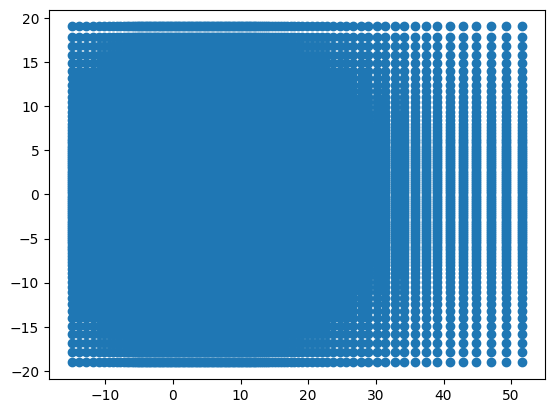

In [4]:
# check for bounding box
plt.scatter(filtered_coordinates[:, 0] / D, filtered_coordinates[:, 1] / D)
plt.show()

In [10]:
dmd = DMD(svd_rank=0, exact=True)
# dmd = DMD(svd_rank=0)
dmd.fit(data)
dmd.original_time["dt"] = dt
dmd.original_time["t0"] = time[0]
dmd.original_time["tend"] = time[-1]

/Users/khawar/anaconda3/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2195644.533067138. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


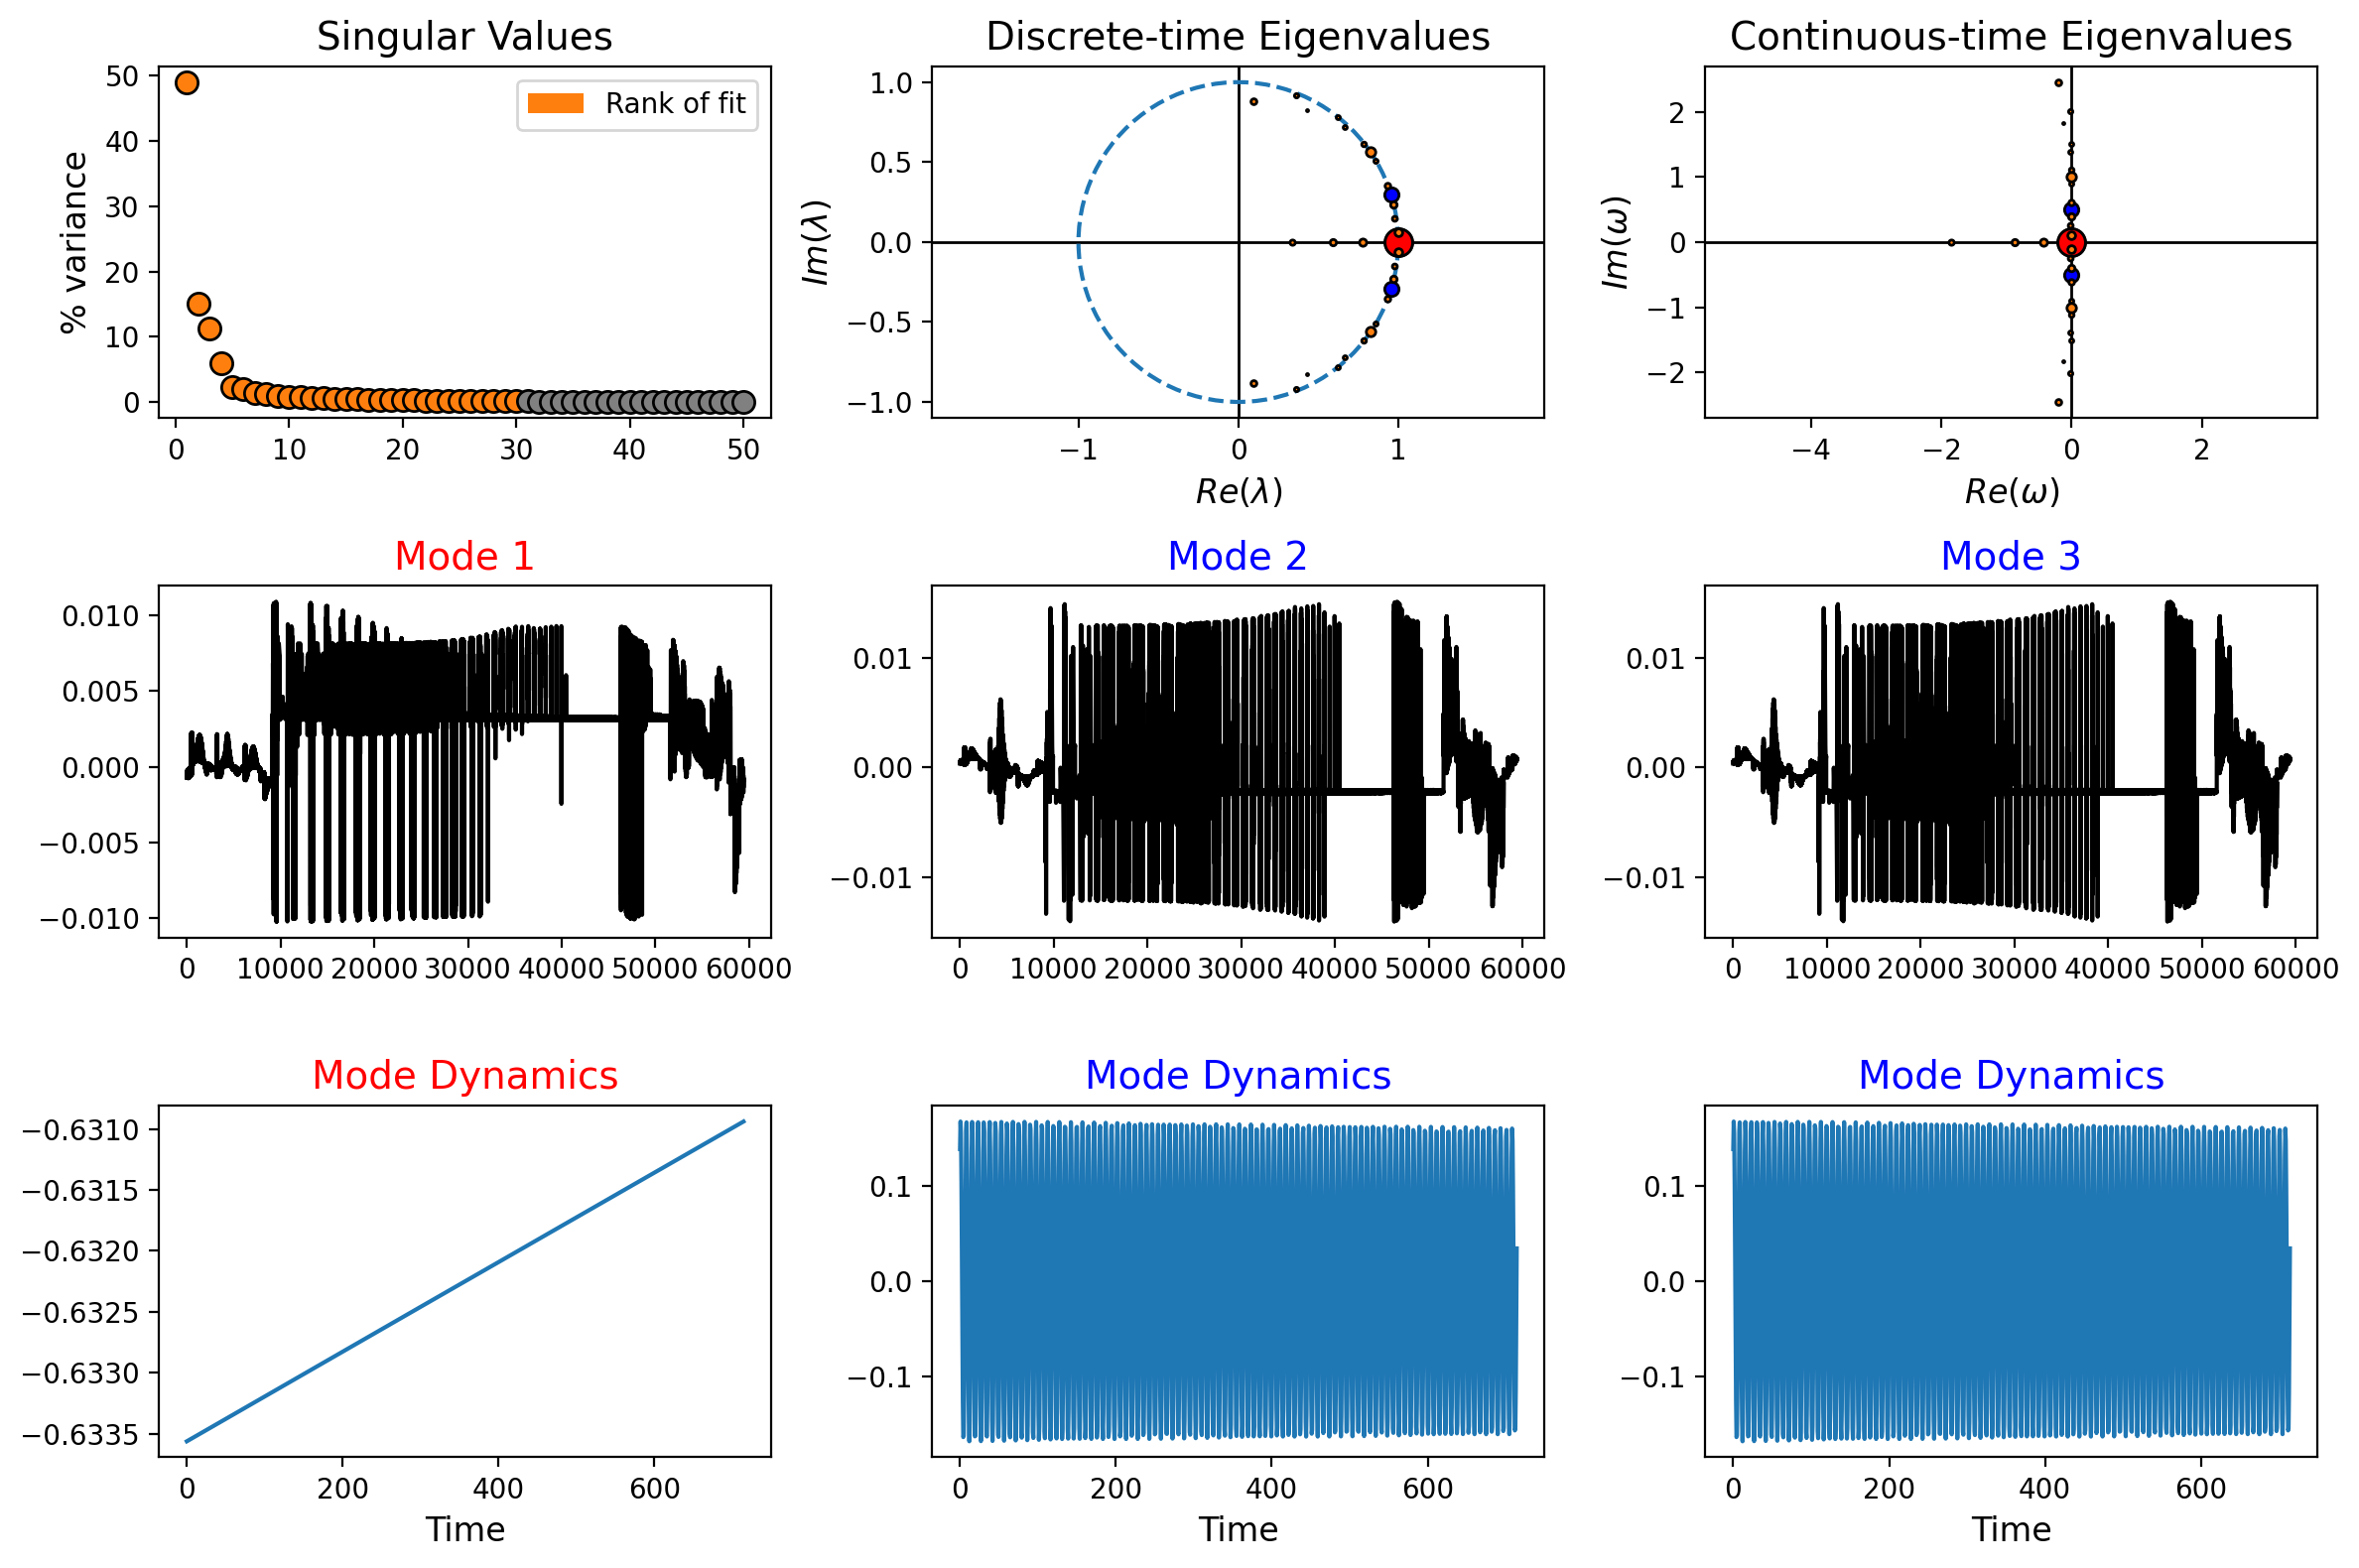

In [6]:
plot_summary(dmd, t=time)

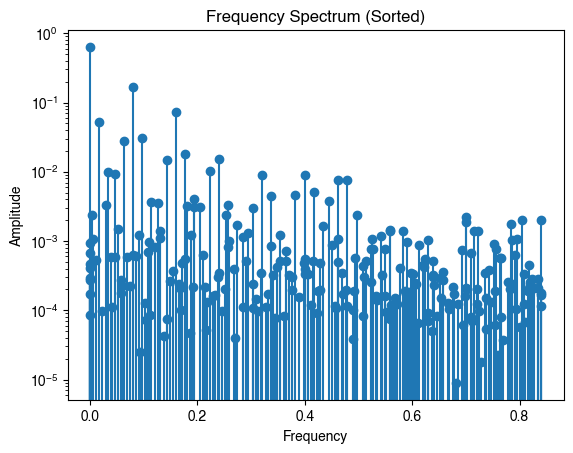

In [11]:
freqs = dmd.frequency
amps = np.abs(dmd.amplitudes)
modes = dmd.modes.real

# Sorting together efficiently:
sort_idx = np.argsort(amps)[::-1]  # Indices for descending sort based on amplitude
freqs = freqs[sort_idx]
amps = amps[sort_idx]
modes = modes[:, sort_idx]

# Filtering for positive frequencies in a single step:
positive_freq_mask = freqs >= 0
freqs = freqs[positive_freq_mask]
amps = amps[positive_freq_mask]
modes = modes[:, positive_freq_mask]

# Plotting:
plt.stem(freqs, amps)
plt.semilogy()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Frequency Spectrum (Sorted)")  # Add a title
plt.show()

In [12]:
np.savetxt("pressure_dmd_modes_pydmd.csv", modes, delimiter=",", fmt="%f")

In [13]:
def plot_contours(x, y, z, G, contours=25, nx=10000, ny=10000/3):
    xi = np.linspace(x.min(), x.max(), int(nx))
    yi = np.linspace(y.min(), y.max(), int(ny))
    zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='cubic')

    X, Y = np.meshgrid(xi, yi)

    x_center1 = 0
    y_center1 = 0.5 + G/2
    x_center2 = 0
    y_center2 = -(0.5 + G/2)
    R = 0.5

    mask1 = (X - x_center1)**2 + (Y - y_center1)**2 <= R**2
    mask2 = (X - x_center2)**2 + (Y - y_center2)**2 <= R**2

    zi[mask1 | mask2] = np.nan  # Apply both masks
    # zi[np.abs(zi) < 1] = 0
    # zi[zi > 10] = 10
    # zi[zi < -10] = -10

    theta = np.linspace(0, 2 * np.pi, 200)
    a = 0.5 * np.cos(theta)
    b = 0.5 * np.sin(theta)

    width = 0.000635 / 0.042
    length = 0.270 / 0.042
    rect1 = mpatches.Rectangle((x_center1, y_center1 - width / 2), length + 0.5, width, angle=0.0, color='gray', alpha=1, zorder=10)
    rect2 = mpatches.Rectangle((x_center2, y_center2 - width / 2), length + 0.5, width, angle=0.0, color='gray', alpha=1, zorder=10)

    rc('font', family='Helvetica')
    rc('text', usetex=False)
    fig, ax = plt.subplots(figsize=(7, 7 / 3))
    plt.contourf(X, Y, zi, levels=contours, cmap='jet')
    plt.colorbar()
    plt.contour(X, Y, zi, levels=contours, colors='k', linewidths=0.1)
    plt.xlim(-5, 25)
    plt.ylim(-5, 5)

    # Add patches after contour lines
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    plt.fill(x_center1 + a, y_center1 + b, color='gray', alpha=1, zorder=10)
    plt.fill(x_center2 + a, y_center2 + b, color='gray', alpha=1, zorder=10)

    plt.xlabel('$x/D$')
    plt.ylabel('$y/D$')

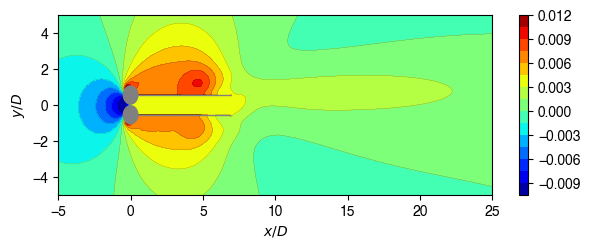

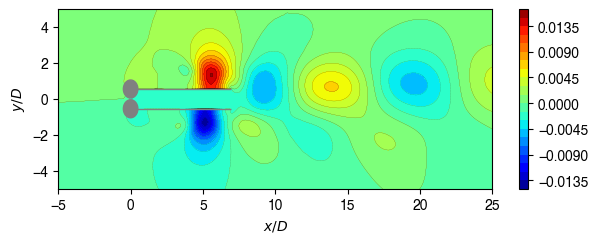

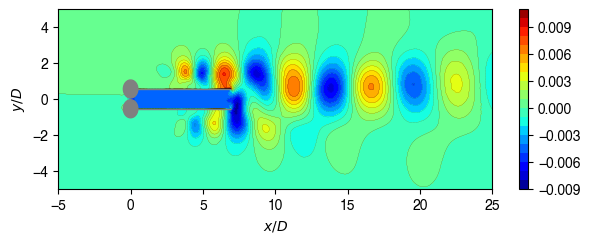

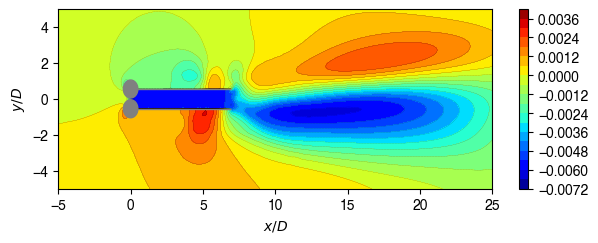

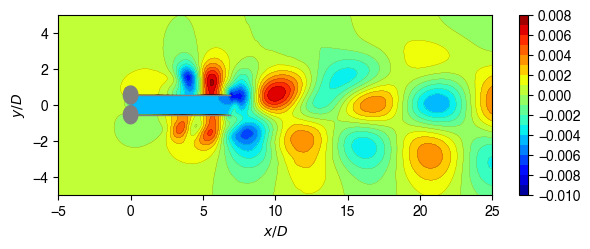

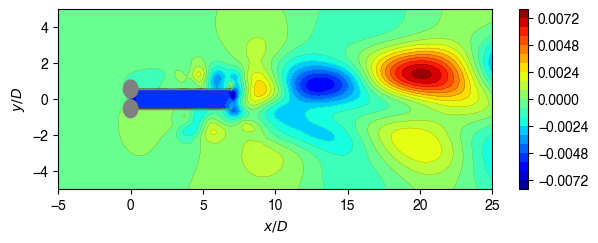

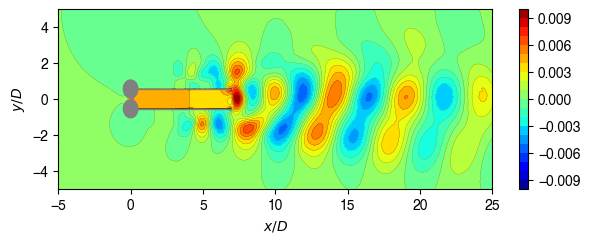

In [14]:
for i in range(7):
    plot_contours(filtered_coordinates[:,0]/D, filtered_coordinates[:,1]/D, modes[:,i],G=0.1, contours=20)
    plt.savefig(f'dmd_mode{i}.png', dpi=600, format='png',bbox_inches='tight')

In [186]:
def plot_eigenvalue_spectrum(dmd):
    real_eigs = dmd.eigs.real
    imag_eigs = dmd.eigs.imag
    circle_theta = np.linspace(0, 2 * np.pi, 200)
    circle_x = np.cos(circle_theta)
    circle_y = np.sin(circle_theta)
    amps = np.abs(dmd.amplitudes)
    amps = (amps - np.min(amps)) / (np.max(amps) - np.min(amps))
    plt.scatter(real_eigs, imag_eigs, s=amps * 200, c=amps, cmap="rainbow", alpha=1)
    plt.plot(circle_x, circle_y, "g--", linewidth=0.5)
    plt.plot([-2, 2], [0, 0], "k-", linewidth=0.5)
    plt.plot([0, 0], [-2, 2], "k-", linewidth=0.5)
    rc("font", family="Helvetica")
    rc("text", usetex=False)
    plt.axis("equal")
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.xlabel("$Re$")
    plt.ylabel("$Im$")
    plt.show()

In [187]:
def plot_eigenvalue_spectrum(dmd):
    """Plots an eigenvalue spectrum with enhanced clarity and customization.

    Args:
        dmd: An object containing eigenvalues (`dmd.eigs`) and amplitudes (`dmd.amplitudes`)
    """

    real_eigs = dmd.eigs.real
    imag_eigs = dmd.eigs.imag

    # Enhanced scatter plot
    plt.scatter(
        real_eigs,
        imag_eigs,
        s=300 * np.abs(dmd.amplitudes),  # Size proportional to magnitude
        c=np.abs(dmd.amplitudes),  # Color by magnitude for clarity
        cmap="rainbow",  # Perceptually uniform colormap
        alpha=1,  # Adjust transparency if needed
        edgecolors=None,
    )  # Remove distracting point edges

    # Unit circle and axes
    rc("font", family="Helvetica")
    rc("text", usetex=False)
    circle_theta = np.linspace(0, 2 * np.pi, 200)

    # fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(np.cos(circle_theta), np.sin(circle_theta), "k--", linewidth=1)
    plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
    plt.plot([0, 0], [-2, 2], "k-", linewidth=1)

    # Formatting
    plt.axis("equal")
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.xlabel("$Re(\omega)$")
    plt.ylabel("$Im(\omega)$")

    # Colorbar for amplitude mapping
    plt.colorbar(label="$|\\alpha|$")
    plt.savefig("eigenvalue_spectrum.png", dpi=600, format="png", bbox_inches="tight")

    plt.show()

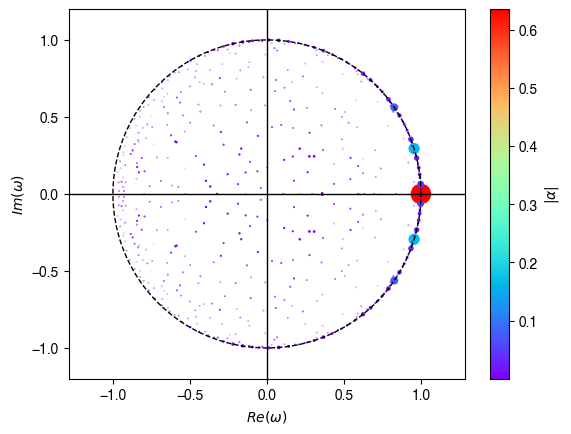

In [188]:
plot_eigenvalue_spectrum(dmd)

In [189]:
def plot_amplitudes(freqs, amps):
    sort_idx = np.argsort(freqs)[::-1]  # Indices for descending sort based on amplitude
    freqs = freqs[sort_idx]
    amps = amps[sort_idx]
    # x = np.zeros((len(freqs), 1))
    # x[amps > 1e-2] = 1
    fig, ax = plt.subplots(figsize=(6, 4))
    # plt.scatter(freqs, amps,s=20, c=x, cmap='coolwarm')
    plt.bar(freqs, amps, width=0.005, color="red", alpha=1)
    plt.semilogy()
    rc("font", family="Helvetica")
    rc("text", usetex=False)
    plt.xlabel("$f^*$")
    plt.ylabel("$|\\alpha|$")
    plt.savefig("amplitudes.eps", dpi=1200, bbox_inches="tight")
    print(amps)
    plt.show()

[2.00010607e-03 1.17093468e-04 1.63886409e-04 1.75763375e-04
 2.12450795e-04 2.84358392e-04 2.06679827e-04 2.81789235e-04
 2.41594664e-04 2.57367547e-04 2.06347987e-04 4.48505399e-04
 1.92997940e-04 6.79391085e-05 1.25309520e-04 3.28904104e-04
 1.99593274e-03 5.72161114e-05 1.06520678e-03 1.03882140e-04
 6.29182723e-04 2.36800474e-04 1.05146344e-03 1.73679630e-03
 2.03067077e-04 2.58373521e-04 3.70006420e-05 5.74464541e-04
 8.03910296e-05 5.62293286e-04 2.24419266e-05 7.68320589e-04
 1.90691757e-04 6.03689308e-05 9.10734055e-04 1.30375104e-04
 3.85121437e-04 5.34164147e-05 1.51791172e-04 3.45068186e-04
 1.81858043e-05 9.84615755e-05 1.38185290e-03 2.03039494e-04
 1.23863589e-04 1.38988634e-03 7.10457014e-05 6.77233838e-04
 7.96139470e-05 2.00200394e-04 2.24033388e-03 1.86670306e-03
 2.11137435e-04 1.62419177e-04 6.04286663e-05 7.42188681e-04
 1.21973380e-04 8.93633728e-06 1.74493814e-04 2.18497620e-04
 1.06007594e-04 1.29073090e-04 2.73478924e-04 3.60035169e-04
 1.50974775e-04 2.939899

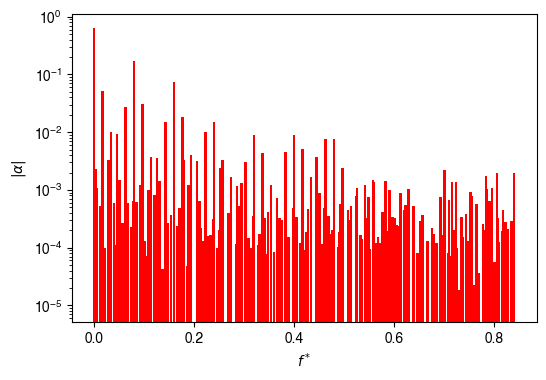

In [190]:
plot_amplitudes(freqs, amps)